* Data Selection: master.CCV - https://www.transit.dot.gov/ntd/data-product/monthly-module-raw-data-release
* Data Preprocessing: data cleaning and data formating for utilization for making new variables
    * Added numeric values to new data frame to make correlation matrix of numeric values.


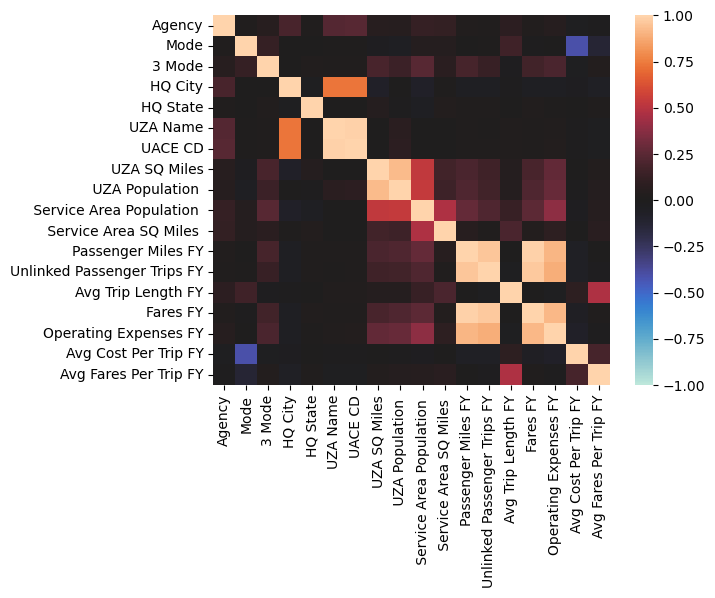

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

"""
file reading resulted in an error. encoding iso fixed the issue reading unkown character
"""
df = pd.read_csv("master.csv", encoding = "ISO-8859-1")

df[' UZA Population '] = df[' UZA Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' UZA Population '] = pd.to_numeric(df[' UZA Population '], errors='coerce')

df[' Service Area Population '] = df[' Service Area Population '].str.replace('-', '0')
df[' Service Area Population '] = df[' Service Area Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area Population '] = pd.to_numeric(df[' Service Area Population '], errors='coerce')

df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace('-', '0')
df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area SQ Miles '] = pd.to_numeric(df[' Service Area SQ Miles '], errors='coerce')

df['Operating Expenses FY'] = df['Operating Expenses FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Operating Expenses FY'] = pd.to_numeric(df['Operating Expenses FY'], errors='coerce')
df['Operating Expenses FY'] = df['Operating Expenses FY'] / 100

df['Fares FY'] = df['Fares FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Fares FY'] = pd.to_numeric(df['Fares FY'], errors='coerce')
df['Fares FY'] = df['Fares FY'] / 100

df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Fares Per Trip FY'] = pd.to_numeric(df['Avg Fares Per Trip FY'], errors='coerce')
df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'] / 100

df['Unlinked Passenger Trips FY'] = df['Unlinked Passenger Trips FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Unlinked Passenger Trips FY'] = pd.to_numeric(df['Unlinked Passenger Trips FY'], errors='coerce')

df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Cost Per Trip FY'] = pd.to_numeric(df['Avg Cost Per Trip FY'], errors='coerce')
df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'] / 100

df['Passenger Miles FY'] = df['Passenger Miles FY'].str.replace(r'[^0-9]', '', regex=True)
df['Passenger Miles FY'] = pd.to_numeric(df['Passenger Miles FY'], errors='coerce')
df = df[df['Passenger Miles FY'] != 0]
df = df[~(df['Status'].isna() | (df['Status'] == 'Inactive'))]

df = df[~(df['HQ City'].isna())]

df = df.drop(columns = ['NTD ID', 'Legacy NTD ID', 'TOS', 'Status', 'Reporter Type', 'Organization Type', 
                   'Most Recent Report Year', 'FY End Month', 'FY End Year'])
string_feats = ['Agency', 'Mode', '3 Mode', 'HQ City', 'HQ State', 'UZA Name']
df_string_feats = df[string_feats]

for feat in string_feats:
    df[feat] = df[feat].astype('category').cat.codes

df_1 = df[['Agency', 'Mode', '3 Mode', 'HQ City','HQ State', 'UZA Name', 'UACE CD', 'UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 
           ' Service Area SQ Miles ', 'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 
           'Operating Expenses FY', 'Avg Cost Per Trip FY', 'Avg Fares Per Trip FY']]
corr_matrix = df_1.corr()
corr_matrix.round(2)

sns.heatmap(corr_matrix, vmin = -1, vmax = 1, center = 0)
plt.show()

df[string_feats] = df_string_feats

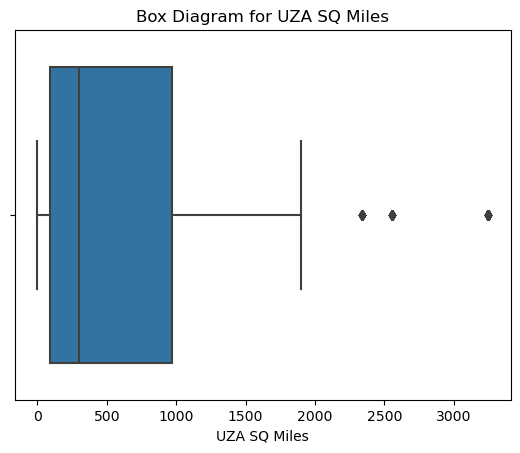

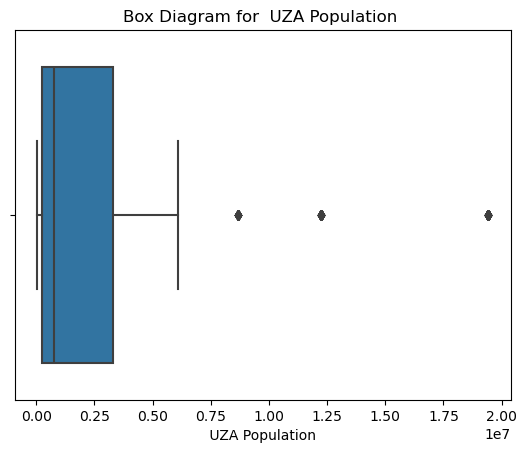

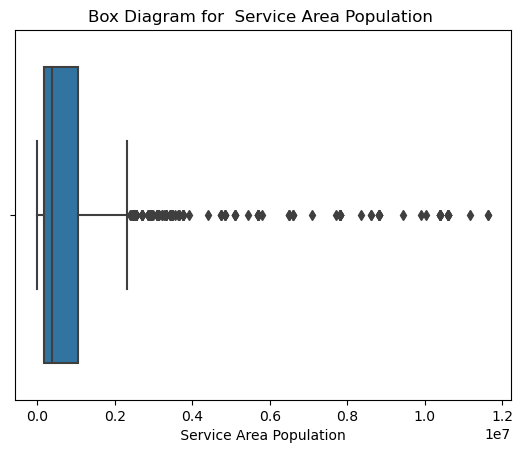

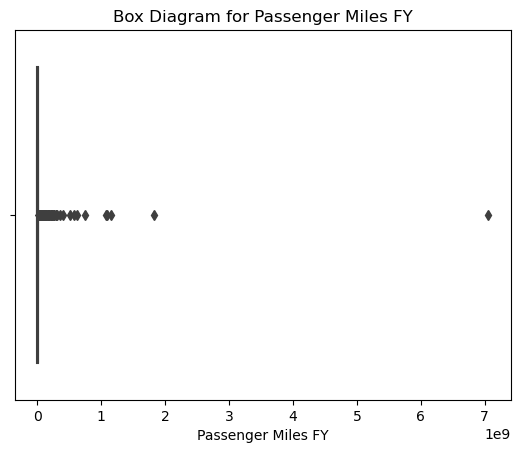

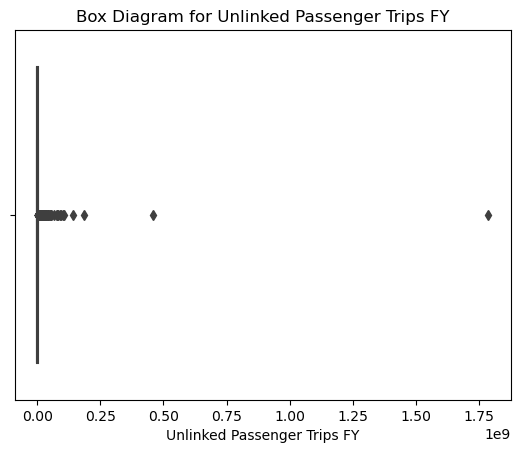

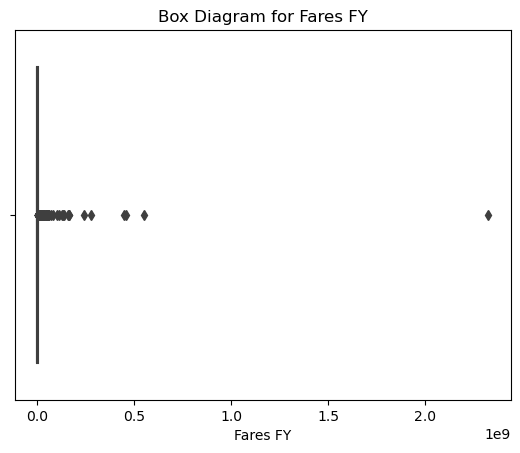

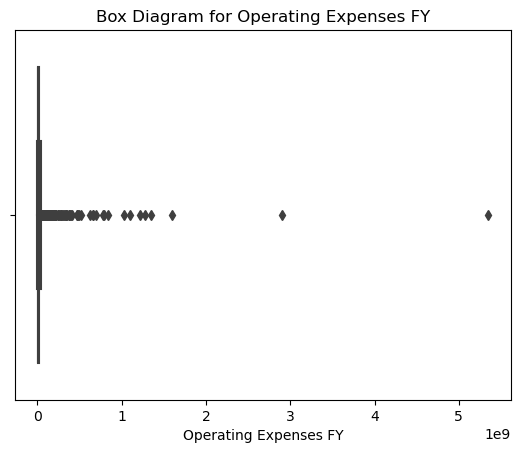

In [2]:
#visualize each feature to better decide on a model (box and whisker diagrams)
features = df[['UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Fares FY', 
           'Operating Expenses FY']]

def show_histograms():
    for feature in features:
        plt.figure()
        sns.boxplot(x=feature, data=df)
        plt.title(f'Box Diagram for {feature}')
        plt.show()

show_histograms()
#plt.savefig("imagename.png")

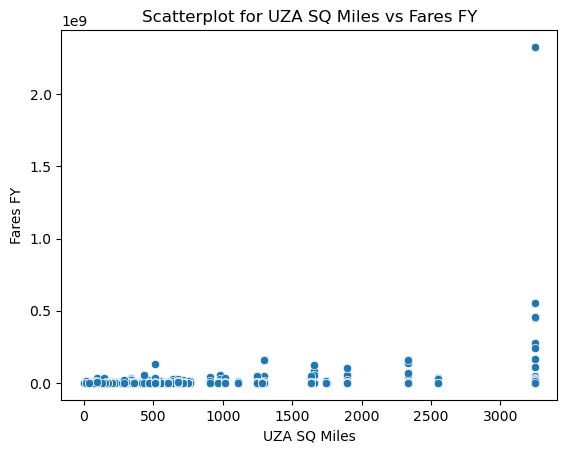

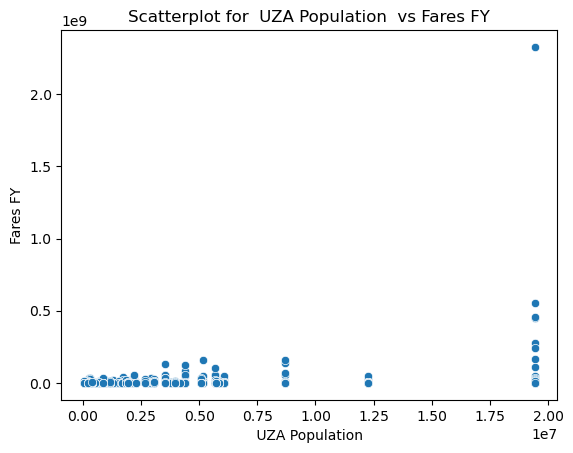

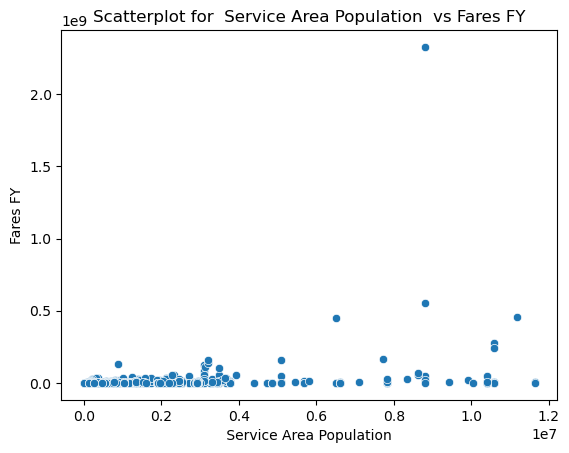

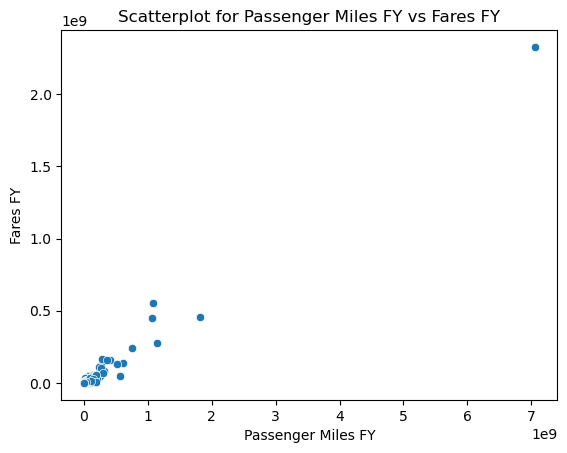

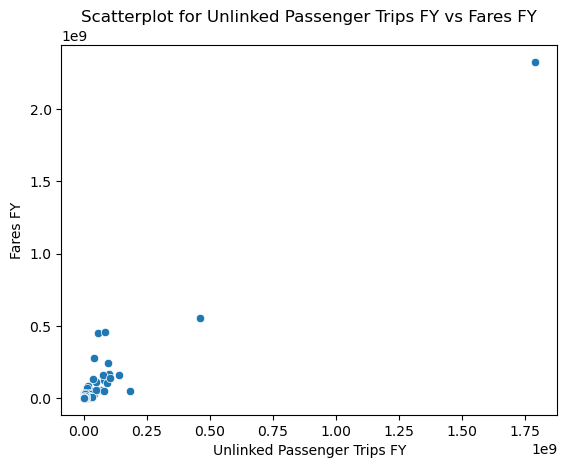

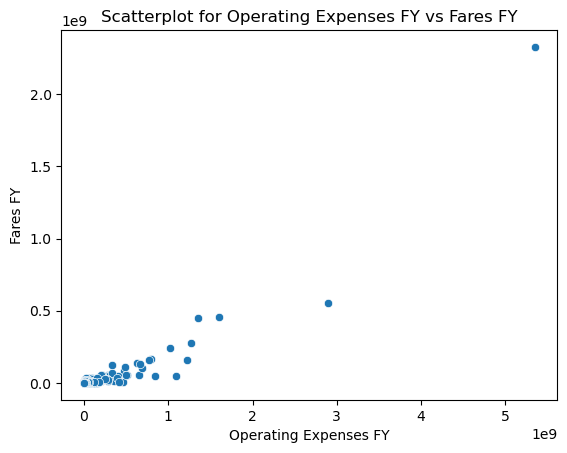

In [3]:
# making the scatterPlot for the making of the features

def show_scatter():
    for feature in features:
        if feature != 'Fares FY':
            plt.figure()
            sns.scatterplot(x=feature, y='Fares FY', data=df)
            plt.title(f'Scatterplot for {feature} vs Fares FY')
            plt.show()

show_scatter()

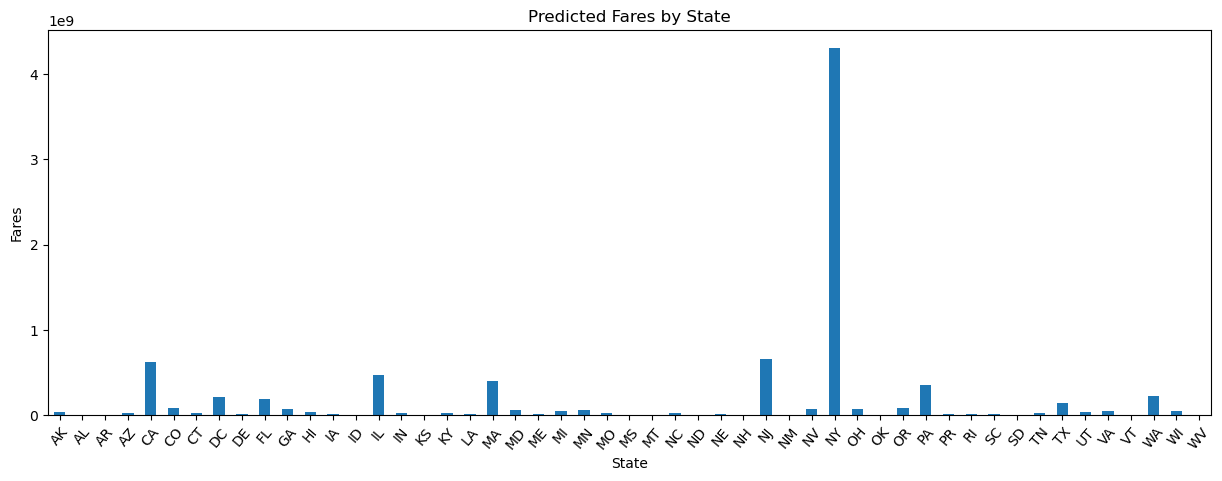

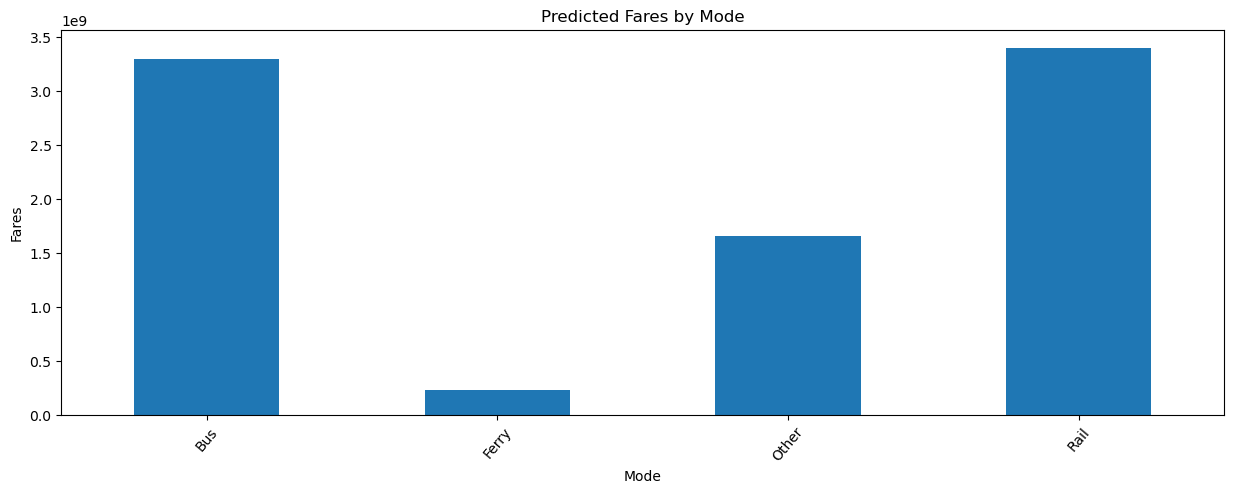

In [4]:
state_revenue = df.groupby('HQ State')['Fares FY'].sum()
# Creating a bar graph of the predicted revenue
plt.figure(figsize=(15, 5))
state_revenue.plot(kind='bar')
plt.title('Predicted Fares by State')
plt.xlabel('State')
plt.ylabel('Fares')
plt.xticks(rotation=50)
plt.show()

mode_revenue = df.groupby('3 Mode')['Fares FY'].sum()
plt.figure(figsize=(15, 5))
mode_revenue.plot(kind='bar')
plt.title('Predicted Fares by Mode')
plt.xlabel('Mode')
plt.ylabel('Fares')
plt.xticks(rotation=50)
plt.show()

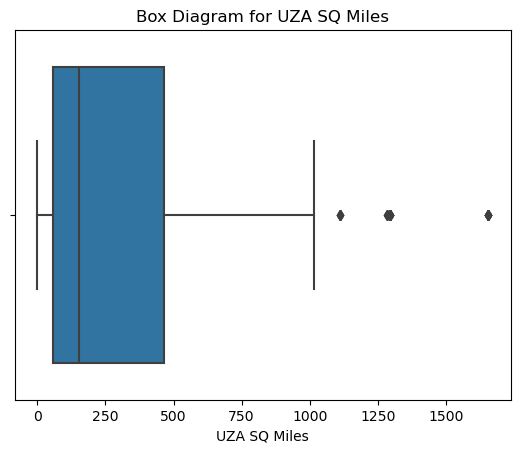

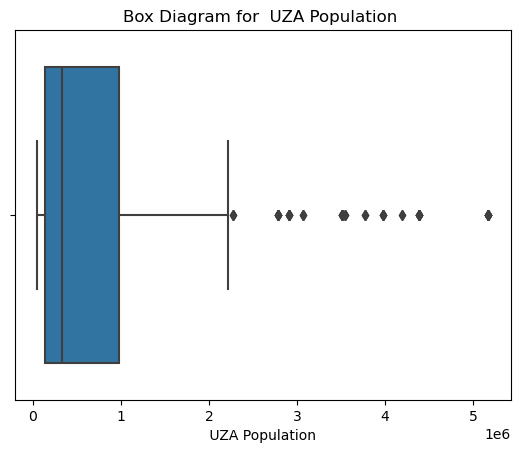

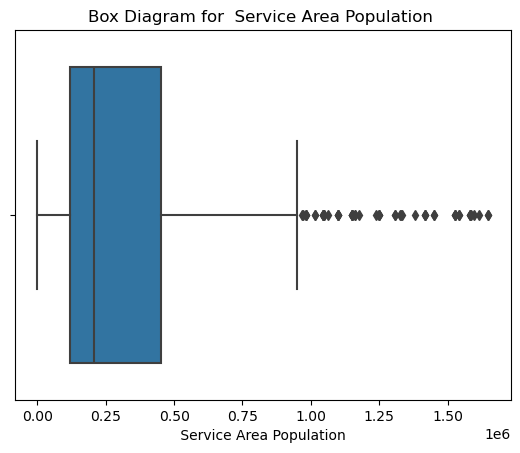

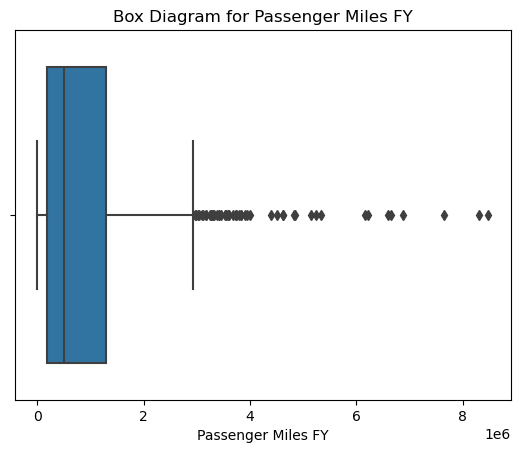

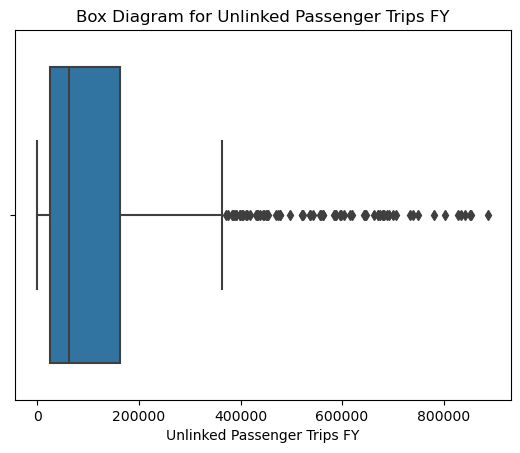

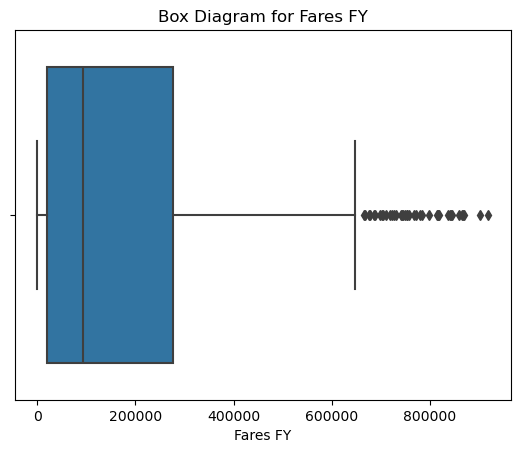

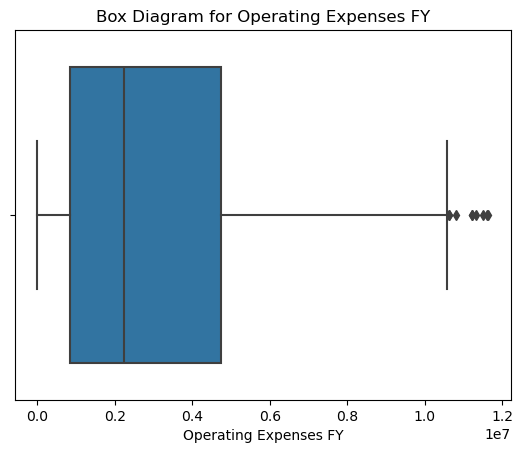

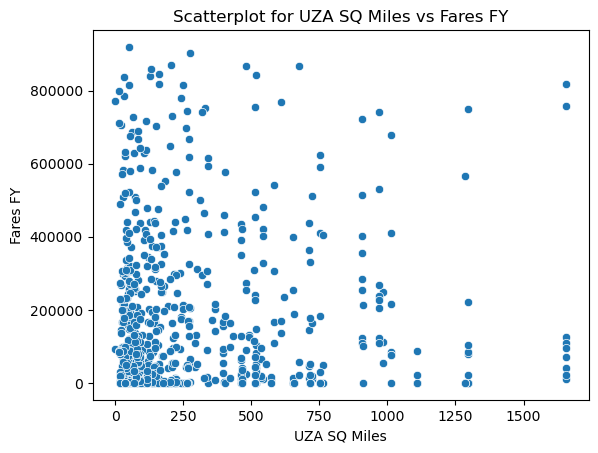

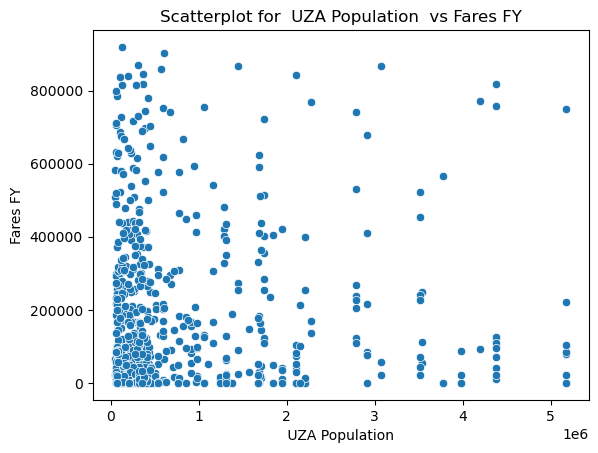

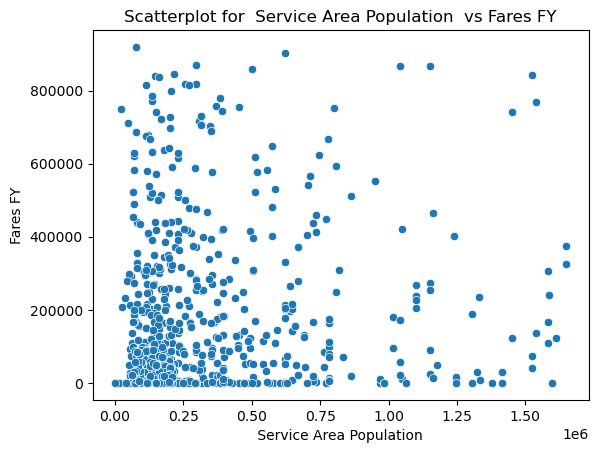

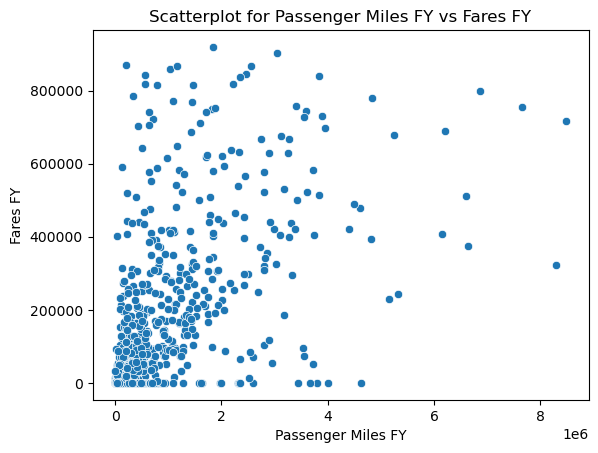

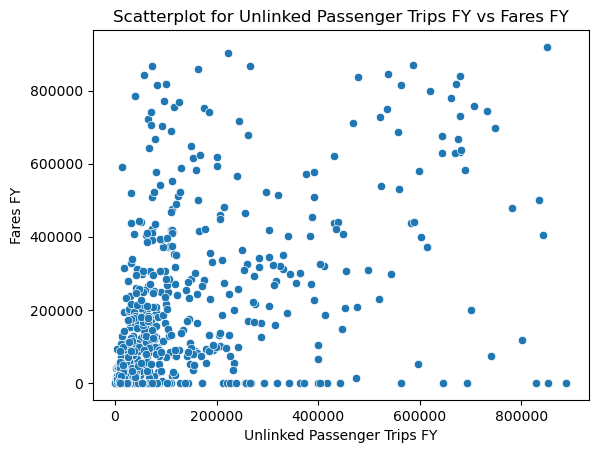

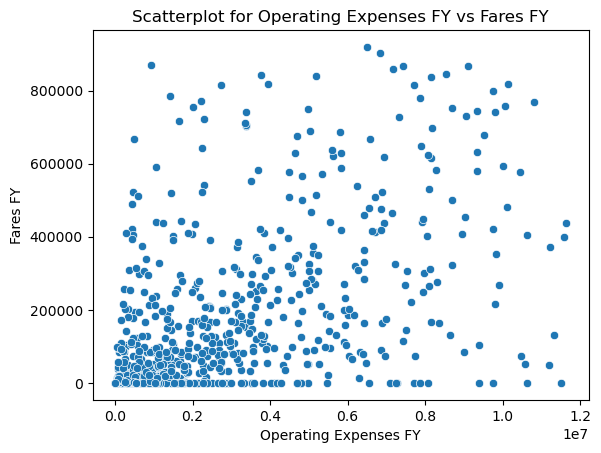

In [5]:
for feature in features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    df = df[df[feature] < q3 + (1.5 * iqr)]
    df = df[df[feature] > q1 + (-1.5 * iqr)]

show_histograms()
show_scatter()

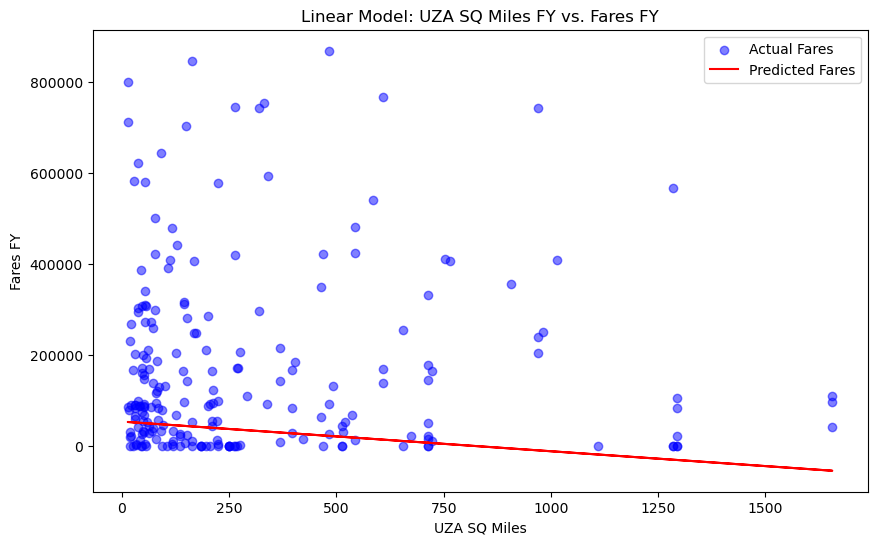

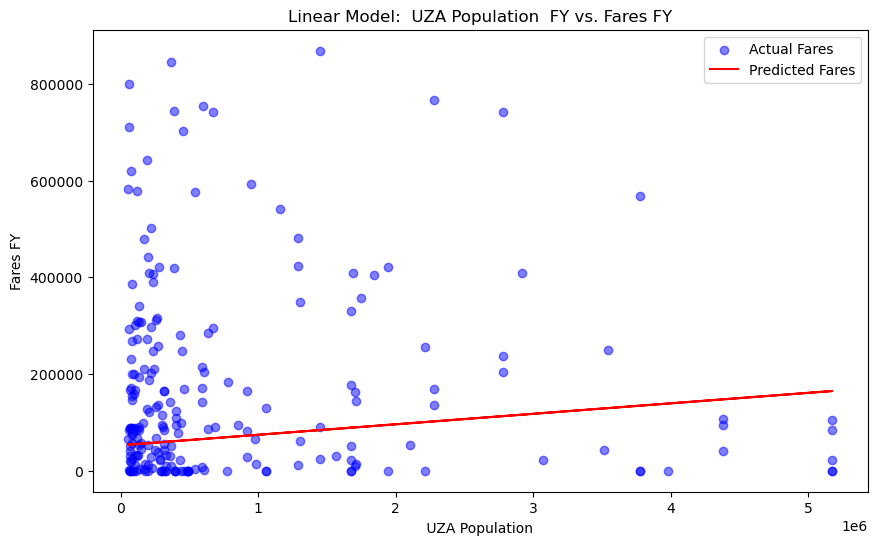

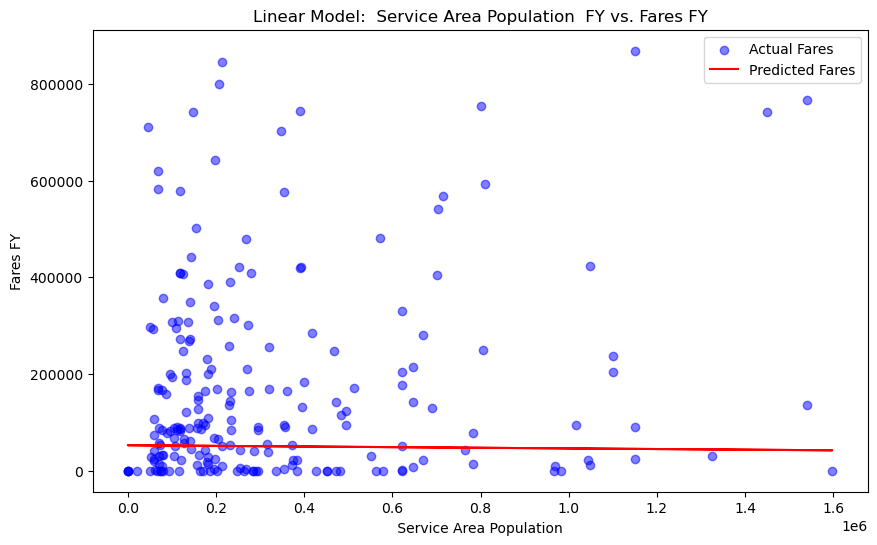

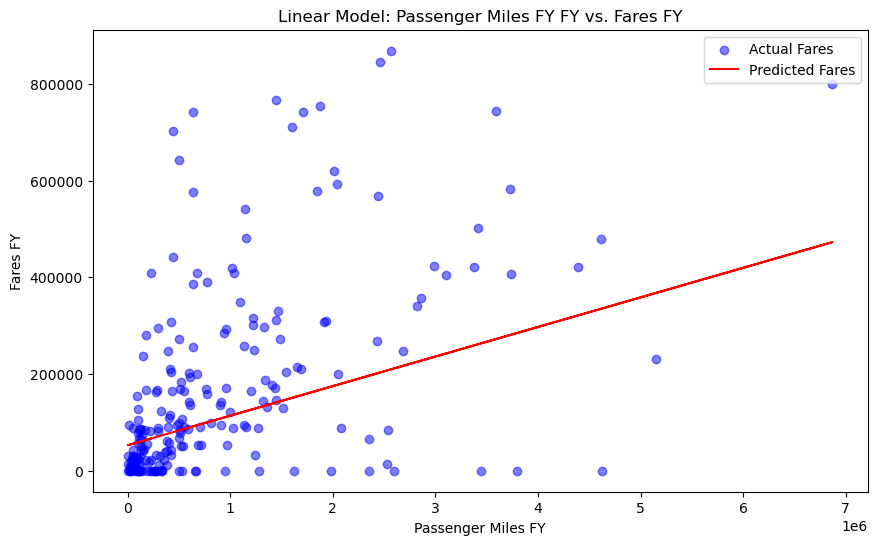

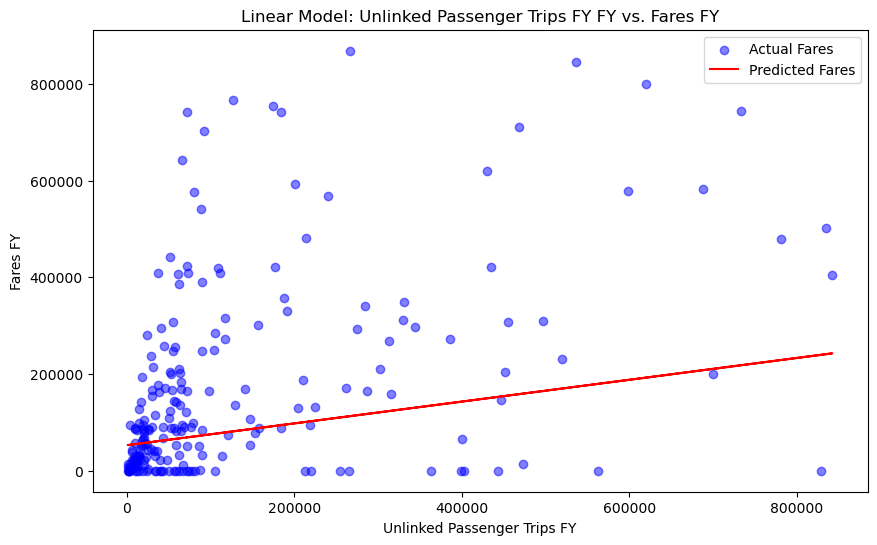

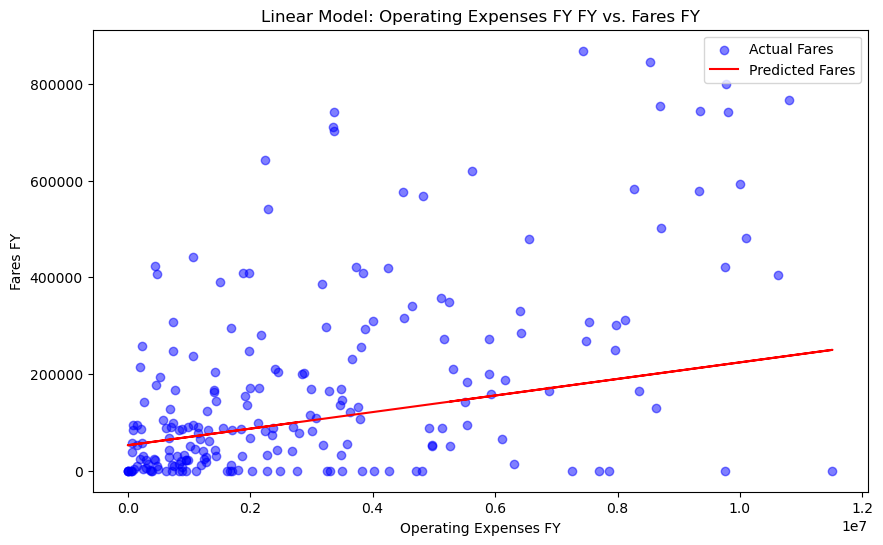

Mean absolute error of linear model: 116718.11432877171


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


high_correlation_feats = df[['UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 
                             'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Operating Expenses FY']]
high_correlation_feats = high_correlation_feats.to_numpy().reshape(-1, 6)
fares = df['Fares FY'].to_numpy()
lin_model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(high_correlation_feats, fares, test_size = 0.33, random_state = 25)
lin_model.fit(x_train, y_train)
pred = lin_model.predict(x_test)

feat_names = ['UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 
              'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Operating Expenses FY']

for i in range(len(feat_names)):
    y_line = []
    for j in range(len(x_test[:, i])):
        y_line.append((lin_model.coef_[i] * x_test[j, i]) + lin_model.intercept_)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[:, i], y_test, color='blue', label='Actual Fares', alpha = 0.5)
    plt.plot(x_test[:, i], y_line, color='red', label='Predicted Fares')
    plt.title(f'Linear Model: {feat_names[i]} FY vs. Fares FY')
    plt.xlabel(feat_names[i])
    plt.ylabel('Fares FY')
    plt.legend()
    plt.show()

print(f'Mean absolute error of linear model: {mean_absolute_error(y_test, pred)}')

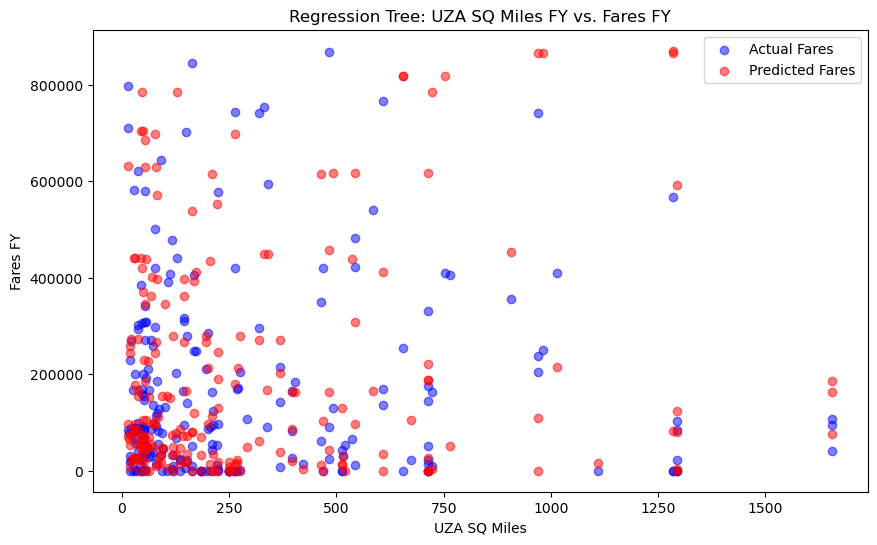

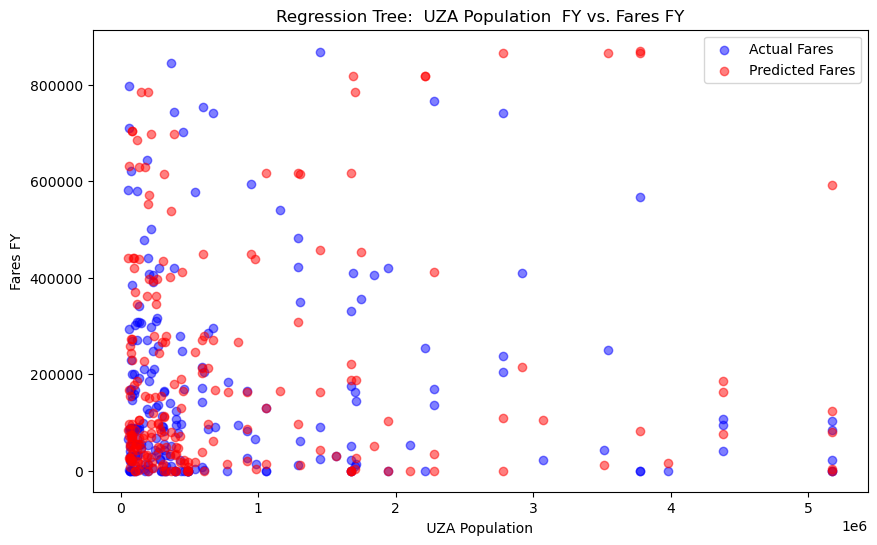

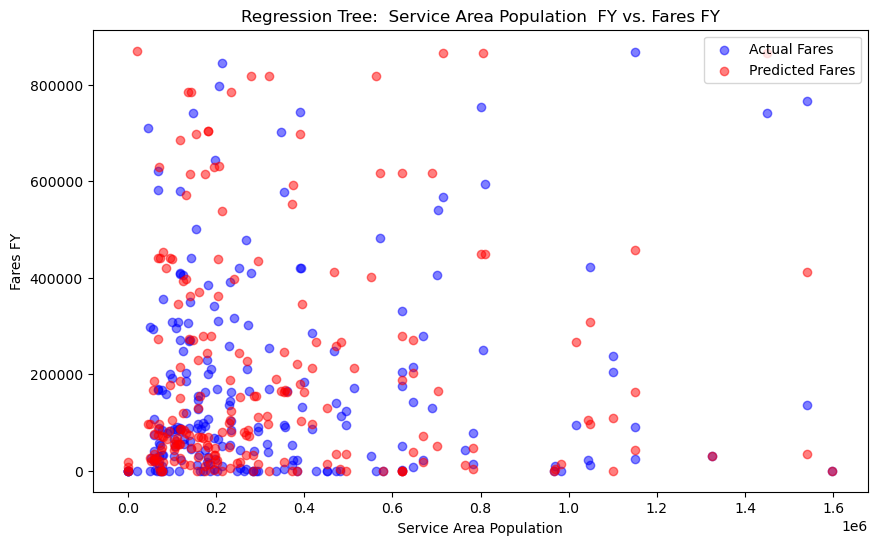

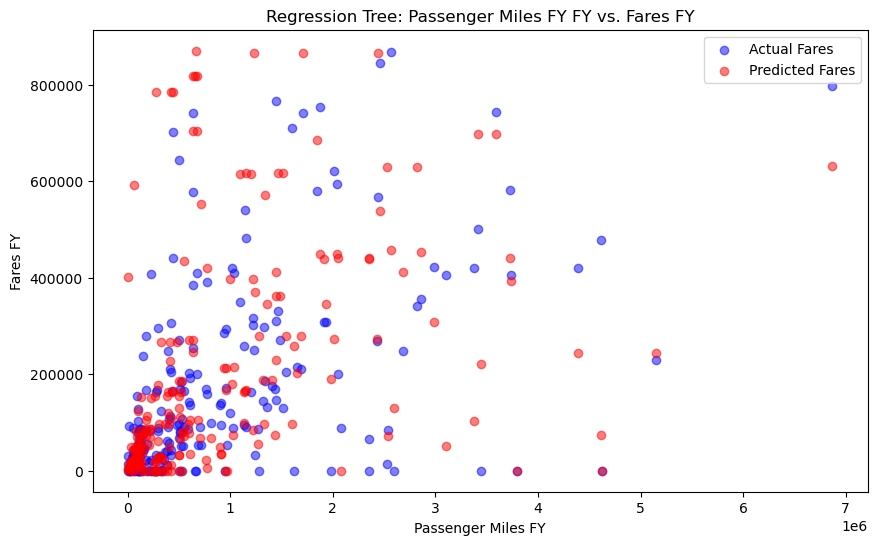

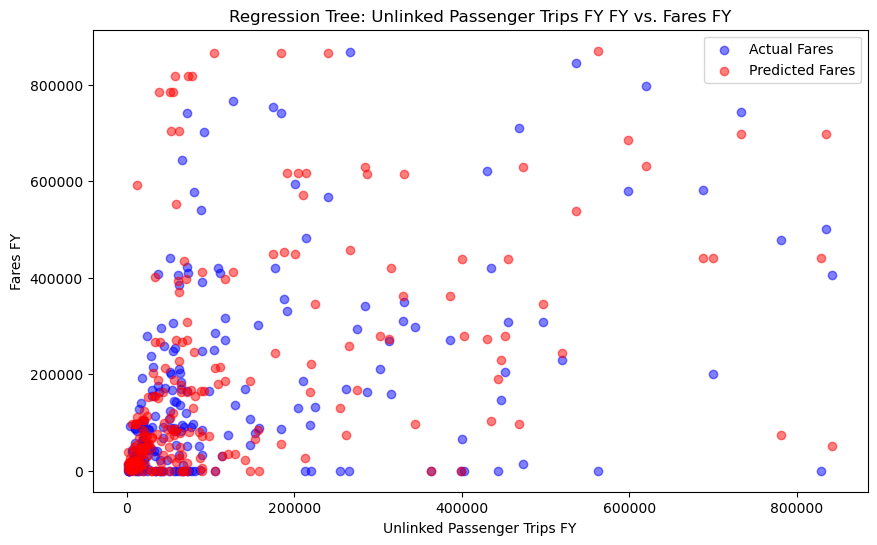

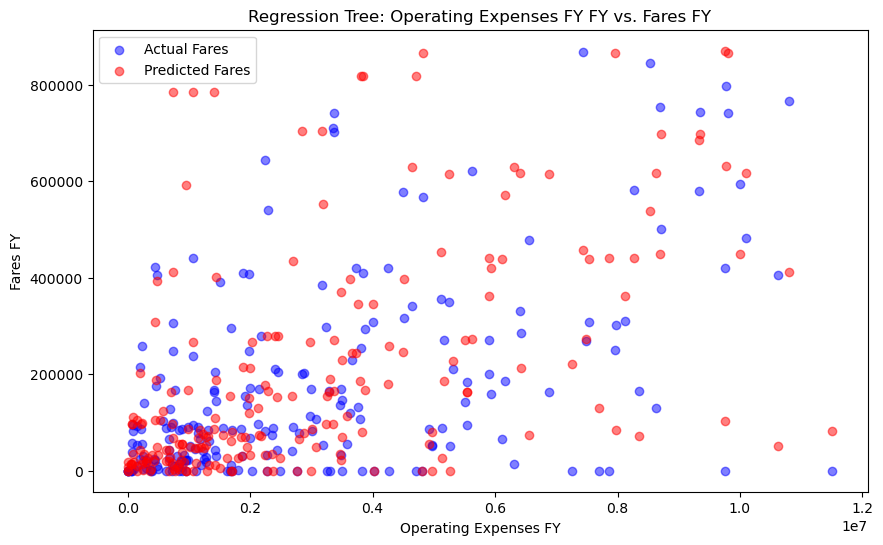

Mean absolute error of regression tree: 141847.22790697674


In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train)
pred = tree_model.predict(x_test)

for i in range(len(feat_names)):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[:, i], y_test, color='blue', label='Actual Fares', alpha = 0.5)
    plt.scatter(x_test[:, i], pred, color='red', label='Predicted Fares', alpha = 0.5)
    plt.title(f'Regression Tree: {feat_names[i]} FY vs. Fares FY')
    plt.xlabel(feat_names[i])
    plt.ylabel('Fares FY')
    plt.legend()
    plt.show()
    
print(f'Mean absolute error of regression tree: {mean_absolute_error(y_test, pred)}')

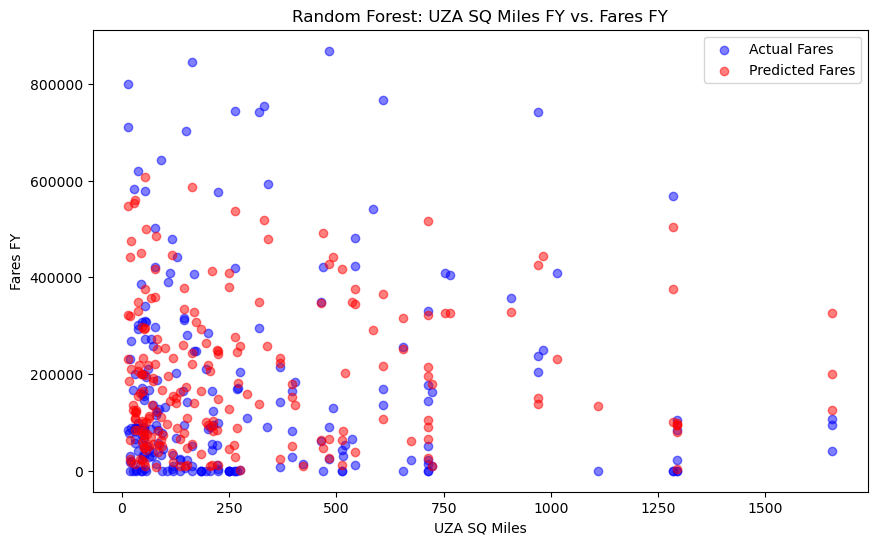

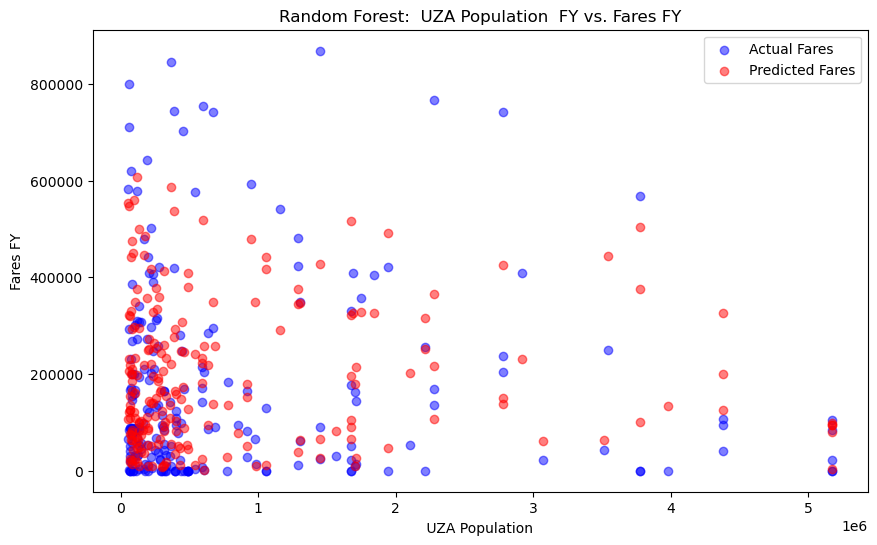

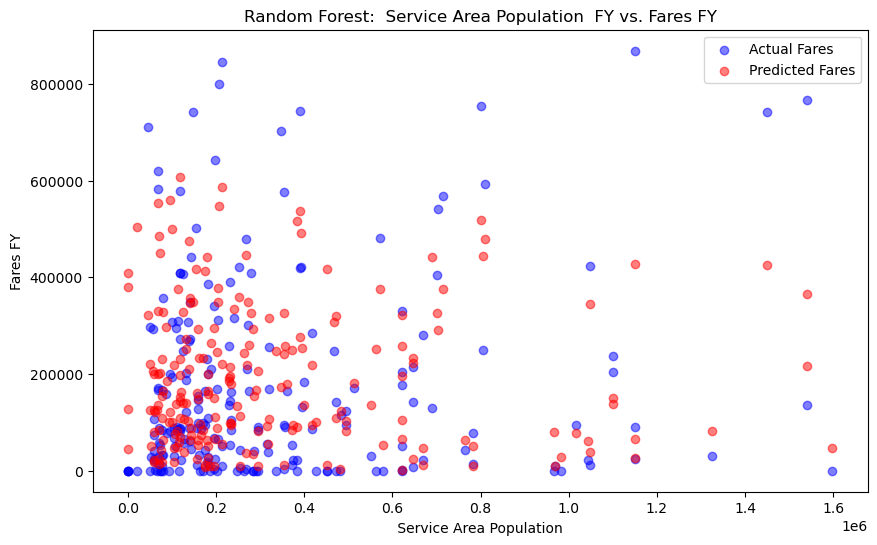

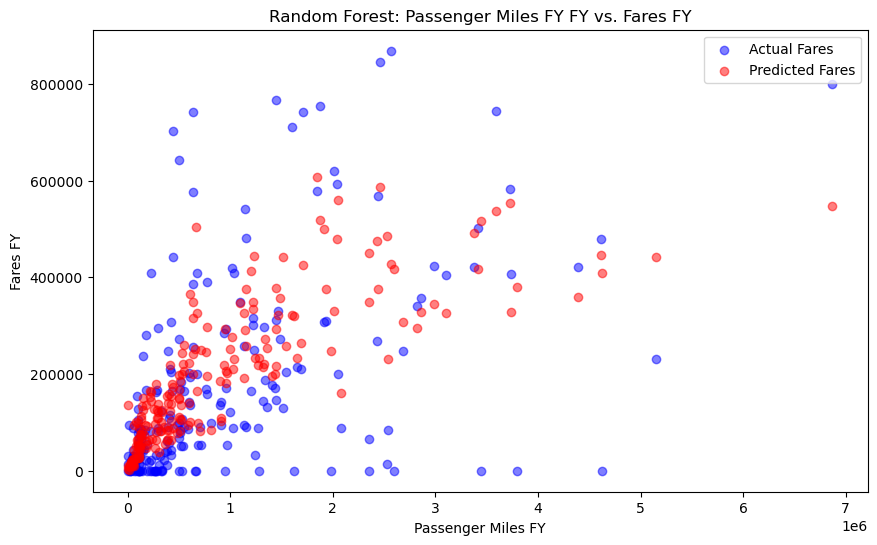

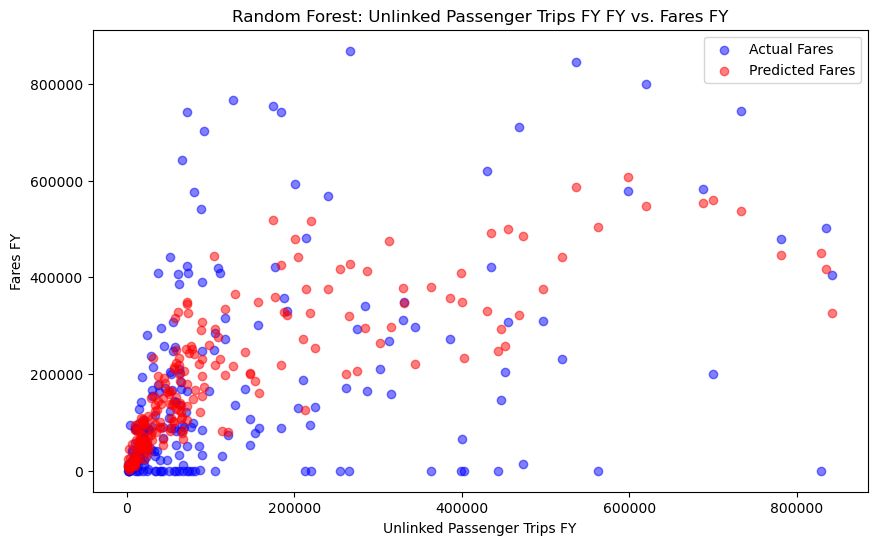

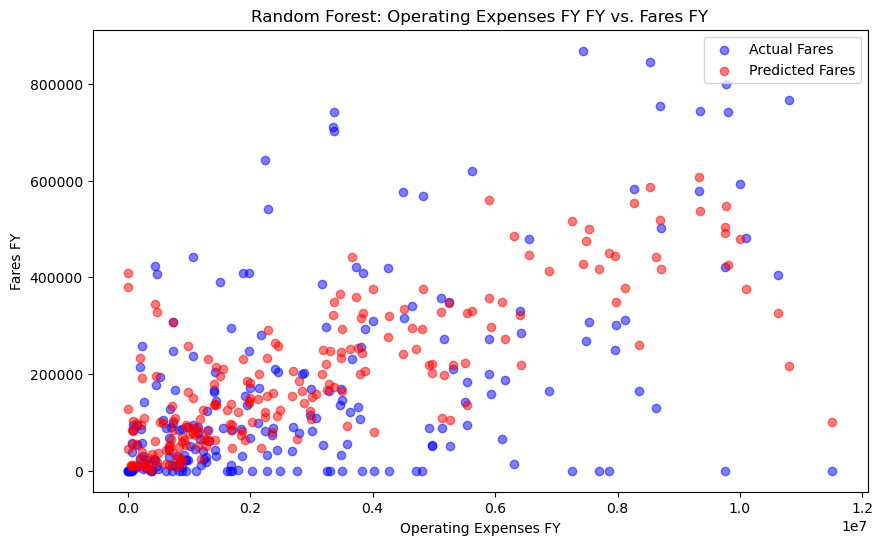

Mean absolute error of random forest: 111571.8808372093


In [8]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(x_train, y_train)
pred = random_forest.predict(x_test)

for i in range(len(feat_names)):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[:, i], y_test, color='blue', label='Actual Fares', alpha = 0.5)
    plt.scatter(x_test[:, i], pred, color='red', label='Predicted Fares', alpha = 0.5)
    plt.title(f'Random Forest: {feat_names[i]} FY vs. Fares FY')
    plt.xlabel(feat_names[i])
    plt.ylabel('Fares FY')
    plt.legend()
    plt.show()

print(f'Mean absolute error of random forest: {mean_absolute_error(y_test, pred)}')

In [9]:
#hyperparamter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params = [{'n_estimators': list(range(10, 101)), 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 
           'min_samples_split': list(range(2, df.shape[0])), 'max_features': ['sqrt', 'log2', None], 
           'bootstrap': [True, False], 'ccp_alpha': [i / 100 for i in range(1, 101)]}]

grid = RandomizedSearchCV(random_forest, param_distributions = params, n_iter = 10, random_state = 25)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'n_estimators': 96, 'min_samples_split': 59, 'max_features': None, 'criterion': 'friedman_mse', 'ccp_alpha': 0.01, 'bootstrap': True}


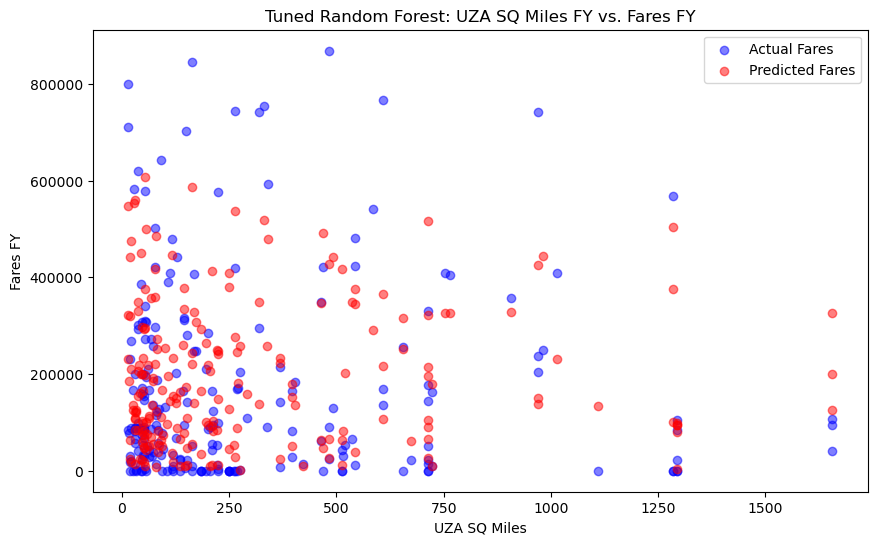

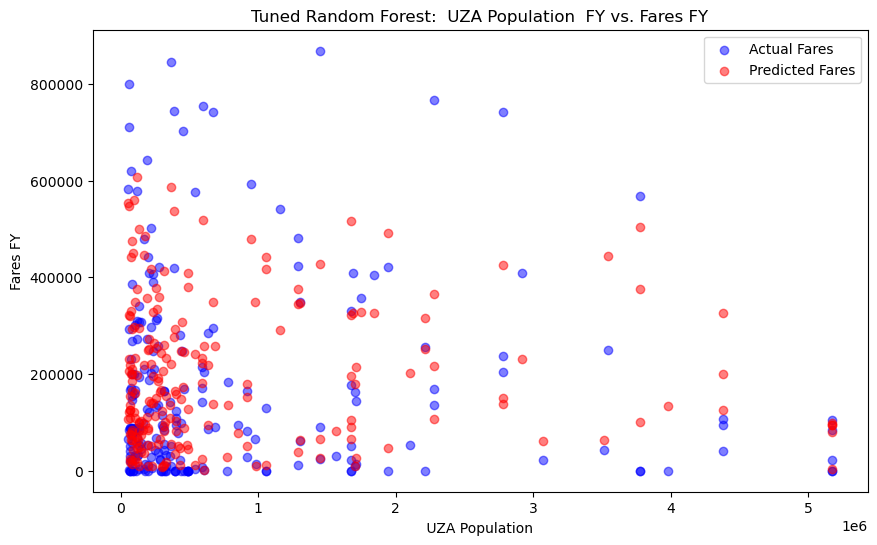

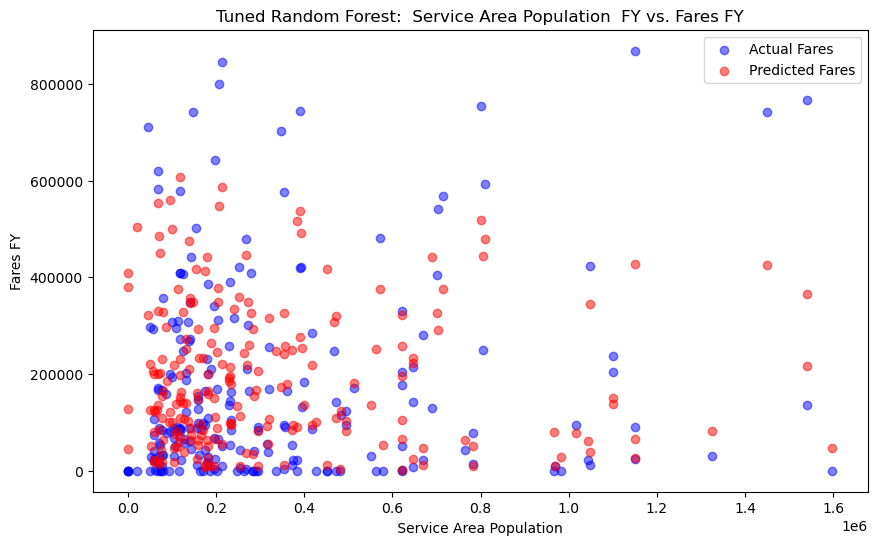

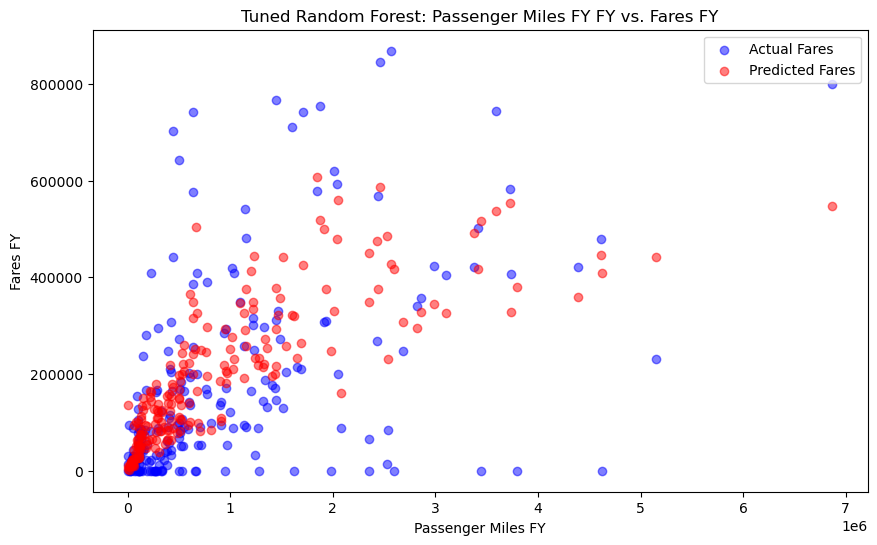

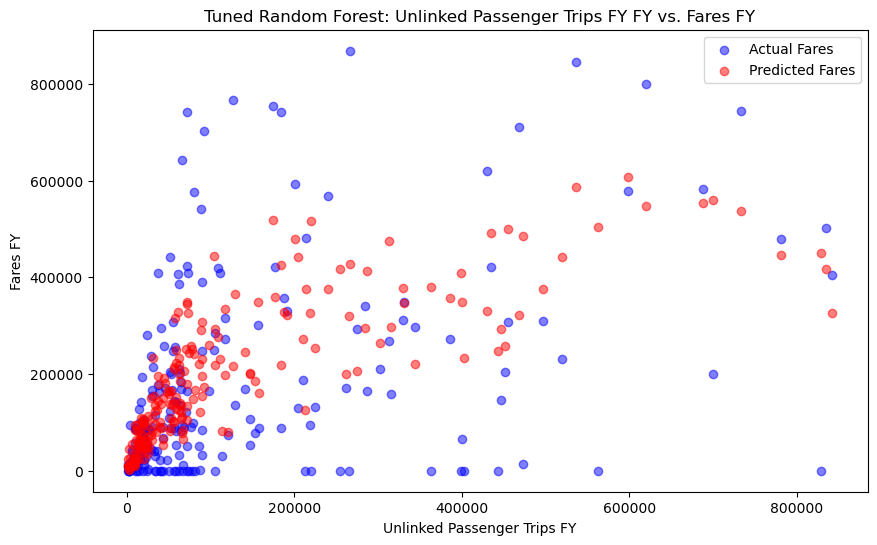

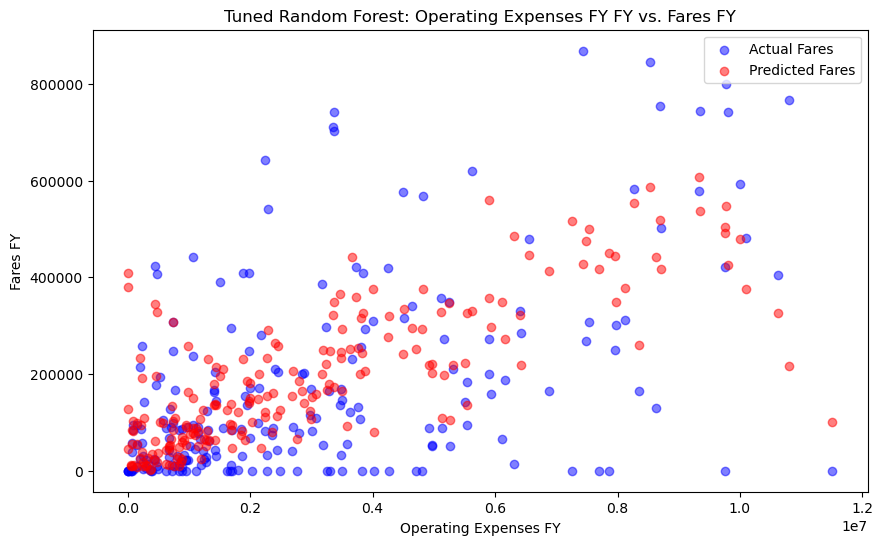

Mean absolute error of random forest: 112173.95672255546


In [10]:
#training a model after tuning

tuned_model = RandomForestRegressor(n_estimators = 96, min_samples_split = 59, max_features = None, 
                                    criterion = 'friedman_mse', ccp_alpha = 0.01, bootstrap = True)
tuned_model.fit(x_train, y_train)
new_pred = tuned_model.predict(x_test)

for i in range(len(feat_names)):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[:, i], y_test, color='blue', label='Actual Fares', alpha = 0.5)
    plt.scatter(x_test[:, i], pred, color='red', label='Predicted Fares', alpha = 0.5)
    plt.title(f'Tuned Random Forest: {feat_names[i]} FY vs. Fares FY')
    plt.xlabel(feat_names[i])
    plt.ylabel('Fares FY')
    plt.legend()
    plt.show()

print(f'Mean absolute error of random forest: {mean_absolute_error(y_test, new_pred)}')

In [11]:
cv_scores = cross_val_score(tuned_model, high_correlation_feats, fares, cv=10, scoring='neg_mean_absolute_error')
print("Cross-Validation Mean Absolute Error: {:.2f}".format(-cv_scores.mean()))
tuned_model.fit(high_correlation_feats, fares)
new_pred = tuned_model.predict(high_correlation_feats)
print("Mean Absolute Error of Random Forest: {:.2f}".format(mean_absolute_error(fares, new_pred)))

Cross-Validation Mean Absolute Error: 117626.53
Mean Absolute Error of Random Forest: 101544.59


In [12]:
import random

new_city = np.array([[0, 0, 0, 0, 0, 0]])

for i in range(6):
    current_feat = feat_names[i]
    new_city[0][i] = random.randint(int(df[current_feat].quantile(0.25)), int(df[current_feat].quantile(0.75)))
    print(f'{current_feat} = {new_city[0][i]}')
print()

print('Predicted revenue: ${:.2f}'.format(tuned_model.predict(new_city)[0]))

UZA SQ Miles = 235
 UZA Population  = 847216
 Service Area Population  = 399848
Passenger Miles FY = 806060
Unlinked Passenger Trips FY = 113667
Operating Expenses FY = 2347557

Predicted revenue: $215723.88
